# FREDから経済データを取得+ベイズ時系列解析

In [ ]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [1]:
using DataFrames
using Dates
using DotEnv
using HTTP
using JSON
using Plots
using Printf

## 経済データの取得

In [2]:
DotEnv.config();

In [3]:
timeseries_url = @sprintf(
    "https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=%s&file_type=json",
    "IPG2211A2N",
    ENV["FRED_API_KEY"])
r = HTTP.get(timeseries_url)

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=UTF-8
Server: Apache
Last-Modified: Wed, 27 Mar 2019 16:21:04 GMT
Expires: Fri, 29 Mar 2019 15:49:42 GMT
x-rate-limit-limit: 120
x-rate-limit-remaining: 120
Date: Fri, 29 Mar 2019 15:49:42 GMT
Transfer-Encoding: chunked
Connection: keep-alive, Transfer-Encoding

{"realtime_start":"2019-03-29","realtime_end":"2019-03-29","observation_start":"1600-01-01","observation_end":"9999-12-31","units":"lin","output_type":1,"file_type":"json","order_by":"observation_date","sort_order":"asc","count":962,"offset":0,"limit":100000,"observations":[{"realtime_start":"2019-03-29","realtime_end":"2019-03-29","date":"1939-01-01","value":"3.3842"},{"realtime_start":"2019-03-29","realtime_end":"2019-03-29","date":"1939-02-01","value":"3.4100"},{"realtime_start":"2019-03-29","realtime_end":"2019-03-29","date":"1939-03-01","value":"3.4875"},{"realtime_start":"2019-03-29","realtime_end":"2019-03-29","date":"1939-04-01","value":

In [4]:
obs_vec = JSON.parse(IOBuffer(r.body))["observations"]

962-element Array{Any,1}:
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-01-01","value"=>"3.3842")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-02-01","value"=>"3.4100")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-03-01","value"=>"3.4875")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-04-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-05-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-06-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-07-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-29","realtime_end"=>"2019-03-29","date"=>"1939-08-01","value"=>"3.6167")  
 Dict{String,A

In [5]:
obs_df = DataFrame(permutedims(hcat(collect.(values.(obs_vec))...), (2, 1)), Symbol.(collect(keys(obs_vec[1]))))

,realtime_start,realtime_end,date,value
,String,String,String,String
1,2019-03-29,2019-03-29,1939-01-01,3.3842
2,2019-03-29,2019-03-29,1939-02-01,3.4100
3,2019-03-29,2019-03-29,1939-03-01,3.4875
4,2019-03-29,2019-03-29,1939-04-01,3.5133
5,2019-03-29,2019-03-29,1939-05-01,3.5133
6,2019-03-29,2019-03-29,1939-06-01,3.5650
7,2019-03-29,2019-03-29,1939-07-01,3.5650
8,2019-03-29,2019-03-29,1939-08-01,3.6167
9,2019-03-29,2019-03-29,1939-09-01,3.7200


In [6]:
for x in [:realtime_start, :realtime_end, :date]
    obs_df[x] = Date.(obs_df[x] ,"y-m-d")
end
obs_df[:value] = parse.(Float64, obs_df[:value])

962-element Array{Float64,1}:
   3.3842
   3.41  
   3.4875
   3.5133
   3.5133
   3.565 
   3.565 
   3.6167
   3.72  
   3.72  
   3.7458
   3.7458
   3.7717
   ⋮     
 104.5716
  93.4491
  93.2405
 103.3083
 113.3178
 113.2758
 101.5656
  95.3546
 103.6453
 113.2436
 124.8584
 116.0108

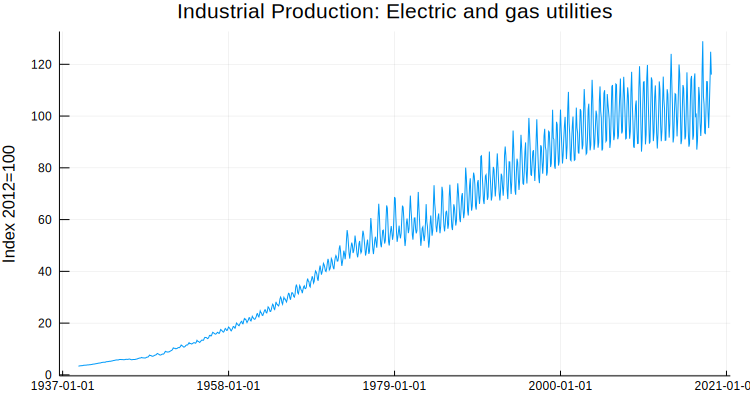

In [7]:
plot(obs_df[:date], obs_df[:value],
    size = [750, 400],
    title = "Industrial Production: Electric and gas utilities",
    ylabel = "Index 2012=100", 
    label = "")

全データを使うとフィッティングに時間がかかるので、2000年以降のデータを対象とする

In [142]:
data_df = obs_df[obs_df[:date] .>= Date(2000,1,1), [:date, :value]]

,date,value
,Date,Float64
1,2000-01-01,102.497
2,2000-02-01,94.5218
3,2000-03-01,88.3463
4,2000-04-01,81.6662
5,2000-05-01,84.7235
6,2000-06-01,91.3293
7,2000-07-01,96.3011
8,2000-08-01,99.6734
9,2000-09-01,90.9515


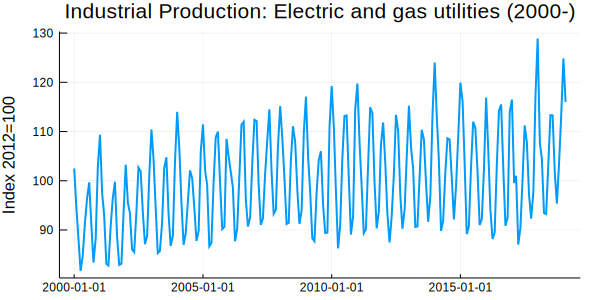

In [162]:
plot(data_df[:date], data_df[:value],
    size = [600, 300],
    linewidth = 2,
    title = "Industrial Production: Electric and gas utilities (2000-)",
    ylabel = "Index 2012=100", 
    label = "")

## Local Level Model

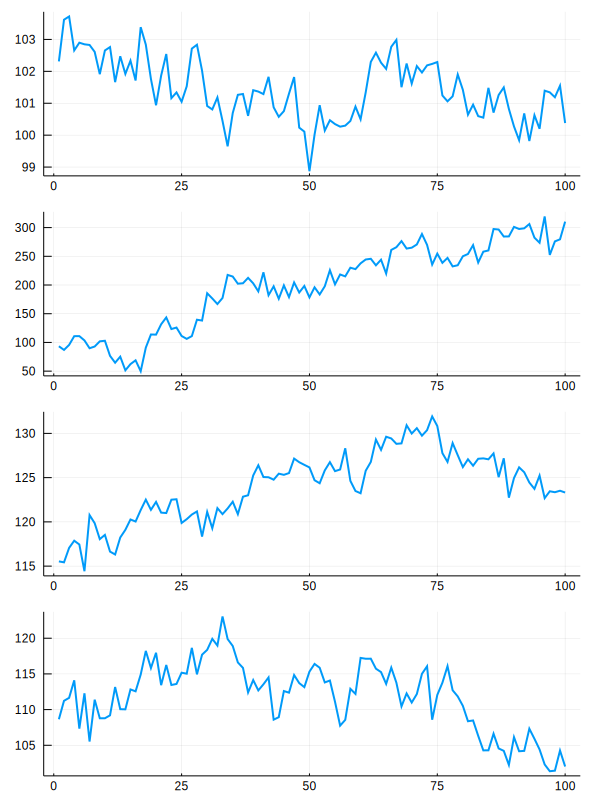

In [143]:
function sample_local_level_model()
    N = 100
    alpha = rand(Truncated(Normal(100, 10), 0, Inf))
    sigma_I = rand(InverseGamma())
    sigma_T = rand(InverseGamma())
    disturbance = rand(MvNormal(zeros(N), sigma_T))
    T = alpha .+ cumsum(disturbance)
    obs = rand(MvNormal(T, sigma_T))
    
    Dict(
        :N => N,
        :alpha => alpha,
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :disturbance => disturbance,
        :T => T,
        :obs => obs,
    )
end

plts = []
for i in 1:4
    sample = sample_local_level_model()
    push!(plts, plot(sample[:obs], linewidth = 2, label = ""))
end
plot(plts..., layout = (4, 1), size = [600, 800])

In [146]:
local_level_model = Model(
    
    obs = Stochastic(1,
        (T, sigma_I) -> MvNormal(T, sqrt(sigma_I)),
        false
    ),
    
    T = Logical(1,
        (alpha, disturbance) -> alpha .+ cumsum(disturbance),
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(zeros(N), sqrt(sigma_T)),
        false
    ),
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    
    alpha = Stochastic(initial -> Normal(initial, 100)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
disturbance:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [170]:
local_level_model_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :initial => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N       => 230
  :initial => 102.497
  :obs     => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 9…

In [179]:
local_level_model_inits = [
    Dict(
        :obs => data_df[:value],
        :T => data_df[:value],
        :disturbance => zeros(size(data_df, 1)),
        :sigma_I => 1,
        :sigma_T => 1,
        :alpha => data_df[:value][1],
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:alpha=>102.497,:sigma_T=>1,:sigma_I=>1,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:alpha=>102.497,:sigma_T=>1,:sigma_I=>1,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],

In [180]:
local_level_model_scheme = [
    AMWG([:disturbance, :alpha], 1.0), Slice([:sigma_I, :sigma_T], 1.0)
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance, :alpha]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:sigma_I, :sigma_T]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                        

In [181]:
setsamplers!(local_level_model, local_level_model_scheme)
local_level_mode_sim = mcmc(
    local_level_model, local_level_model_data, local_level_model_inits, 
    25000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [0:25:00 of 0:25:01 remaining]
      From worker 3:	Chain 2:   0% [0:24:33 of 0:24:34 remaining]
      From worker 4:	Chain 3:   0% [0:24:18 of 0:24:19 remaining]
      From worker 2:	Chain 1:  10% [0:02:26 of 0:02:42 remaining]
      From worker 3:	Chain 2:  10% [0:02:27 of 0:02:43 remaining]
      From worker 4:	Chain 3:  10% [0:02:31 of 0:02:47 remaining]
      From worker 2:	Chain 1:  20% [0:02:07 of 0:02:39 remaining]
      From worker 3:	Chain 2:  20% [0:02:10 of 0:02:42 remaining]
      From worker 4:	Chain 3:  20% [0:02:11 of 0:02:43 remaining]
      From worker 2:	Chain 1:  30% [0:01:54 of 0:02:42 remaining]
      From worker 3:	Chain 2:  30% [0:01:55 of 0:02:45 remaining]
      From worker 4:	Chain 3:  30% [0:01:57 of 0:02:47 remaining]
      From worker 2:	Chain 1:  40% [0:01:36 of 0:02:39 remaining]
      From worker 3:	Chain 2:  40% [0:01:37 of 0:02:42 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[87.4548 1.05754 … 108.538 107.868; 87.4171 0.867591 … 106.547 106.471; … ; 85.1632 0.155059 … 103.746 104.089; 85.3277 0.178178 … 105.713 105.993]

[92.5348 0.272438 … 107.092 107.085; 92.2457 0.173961 … 105.173 105.166; … ; 83.4655 0.697589 … 109.093 108.782; 82.8807 0.505795 … 105.183 104.309]

[96.5326 0.501541 … 102.832 101.789; 98.0718 0.759801 … 101.795 101.786; … ; 78.9419 0.425786 … 108.136 107.374; 80.0606 0.352645 … 109.984 108.69]

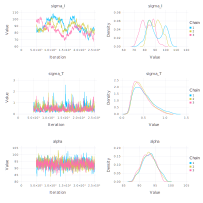

In [182]:
p = Mamba.plot(local_level_mode_sim[:, [:sigma_I, :sigma_T, :alpha], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

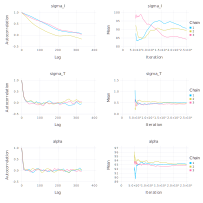

In [183]:
p = Mamba.plot(local_level_mode_sim[:, [:sigma_I, :sigma_T, :alpha], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

In [184]:
Ts = quantile(local_level_mode_sim[:, [:T], :]).value

230×5×1 Array{Float64,3}:
[:, :, 1] =
  88.2195   91.4454   93.032    94.6424   97.9073
  88.3267   91.4012   92.9892   94.5395   97.7191
  88.3903   91.4249   92.9013   94.4143   97.5288
  88.3531   91.3817   92.8841   94.3584   97.3763
  88.5619   91.4606   92.8885   94.3503   97.3117
  88.6552   91.5589   92.9702   94.3733   97.2394
  88.7992   91.6226   93.0222   94.4034   97.2321
  88.87     91.7247   93.0792   94.4077   97.3314
  88.9213   91.7689   93.0718   94.4249   97.2137
  89.0593   91.8031   93.1219   94.458    97.1314
  89.2976   91.8882   93.1957   94.5029   97.1643
  89.3897   92.0097   93.3081   94.5994   97.1911
  89.5306   92.0514   93.3641   94.6422   97.1661
   ⋮                                             
 101.031   103.472   104.735   106.049   108.607 
 101.001   103.474   104.804   106.105   108.729 
 101.134   103.55    104.898   106.255   108.884 
 101.197   103.681   105.058   106.448   109.159 
 101.29    103.833   105.215   106.604   109.465 
 101.418   1

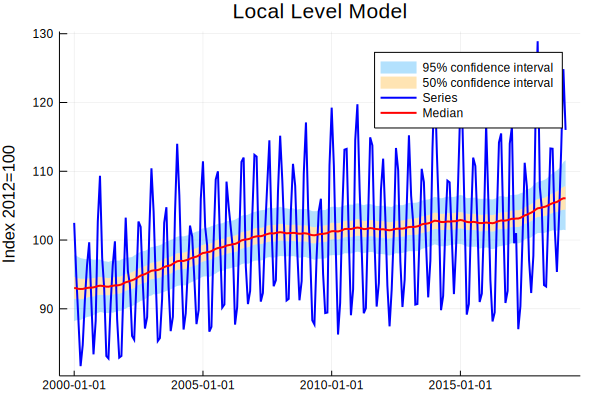

In [195]:
plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model",
    ylabel = "Index 2012=100", 
    label = "Series")
plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")